# iterative image reconstruction from fourier transform

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

## utils

In [2]:
def normalize(value):
    '''
    normalizes channel of image
    '''
    minimum = value.min()
    maximum = value.max()
    return (value - minimum)/(maximum - minimum)

def normalizeAll(image):
    '''
    normalizes all channels of image
    '''
    image = image.copy()
    image[:,:,0] = normalize(image[:,:,0])
    image[:,:,1] = normalize(image[:,:,1])
    image[:,:,2] = normalize(image[:,:,2])
    return image

def rOrder(M, N, step = 4, seed = 1):
    np.random.seed(seed)
    m, n = np.arange(M), np.arange(N)
    S, T = np.meshgrid(m, n)
    cs, ct = M//2, N//2
    R = np.maximum(np.abs(cs - S), np.abs(ct - T))
    rs, rt = M//step, N//step
    a, b = 0, max(cs, ct)/step
    order = [(cs, ct)]
    for s in range(step):
        c = b*(s + 1)
        x, y = np.where(np.logical_and(R > a, R <= c))
        kernel = list(zip(x, y))
        np.random.shuffle(kernel)
        order += list(kernel)
        a = c
    return order

In [3]:
rDict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.5, 0.5),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
        }

gDict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.5, 0.5),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

bDict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.5, 0.5),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

cRed = LinearSegmentedColormap('colorMapRed', rDict)
cGreen = LinearSegmentedColormap('colorMapGreen', gDict)
cBlue = LinearSegmentedColormap('colorMapBlue', bDict)

### input image

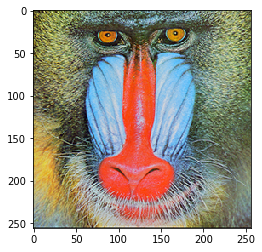

In [4]:
x = Image.open('input/babuino.png')
x = np.asarray(x)/255
# N1 => y axis
# N2 => x axis
N1, N2, _ = x.shape

### split channels ###
r, g, b = x[:,:,0], x[:,:,1], x[:,:,2]

plt.imshow(x)
plt.show()

# fourier transform

In [5]:
R = np.fft.fft2(r)
R = np.fft.fftshift(R)
G = np.fft.fft2(g)
G = np.fft.fftshift(G)
B = np.fft.fft2(b)
B = np.fft.fftshift(B)

### display frequency analysis ###
Rd, Gd, Bd = x*0, x*0, x*0
rlog = np.log10(1 + np.abs(R))
Rd[:,:,0] = normalize(rlog)
glog = np.log10(1 + np.abs(G))
Gd[:,:,1] = normalize(glog)
blog = np.log10(1 + np.abs(B))
Bd[:,:,2] = normalize(blog)

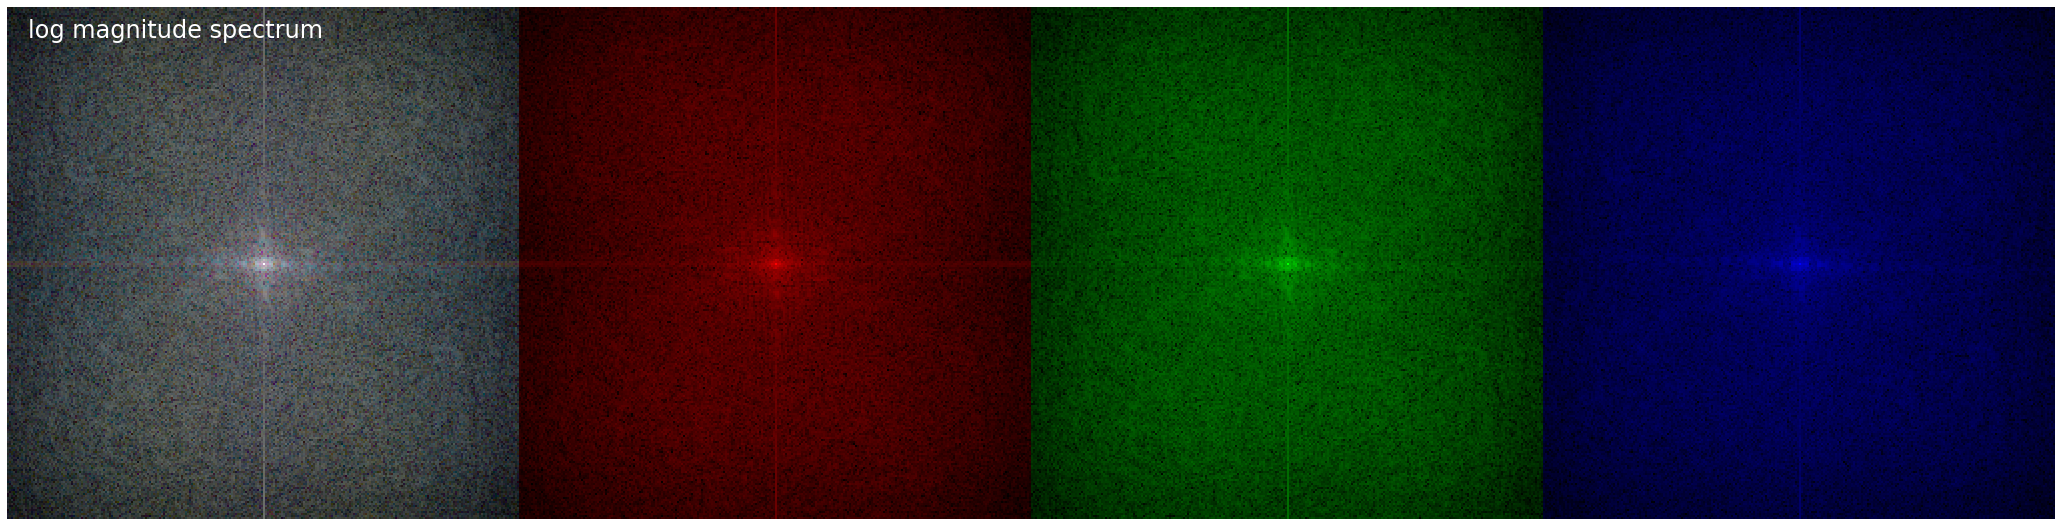

In [6]:
fig = plt.figure(figsize = (2048/72, 512/72))
gs = gridspec.GridSpec(1, 4)
gs.update(left = 0, right = 1, bottom = 0, top = 1, wspace = 0, hspace = 0)
axSpec = plt.subplot(gs[0, 0]); axSpec.axis('off')
axSpecRed = plt.subplot(gs[0, 1]); axSpecRed.axis('off')
axSpecGreen = plt.subplot(gs[0, 2]); axSpecGreen.axis('off')
axSpecBlue = plt.subplot(gs[0, 3]); axSpecBlue.axis('off')

axSpecRed.imshow(Rd)
axSpecGreen.imshow(Gd)
axSpecBlue.imshow(Bd)
axSpec.imshow(Rd + Gd + Bd)
axSpec.text(10, 15, 'log magnitude spectrum', color = 'white', size = 24)

plt.show()


# reconstruction visualization

In [7]:
n1 = np.arange(N1)/N1
n1 = np.array([n1]).T
n1 = np.tile(n1, (1, N1))
n2 = np.arange(N2)/N2
n2 = np.tile(n2, (N2, 1))

### init visualization ###
rd, gd, bd, out = x*0, x*0, x*0, x*0
maxRadius = max(N1, N2)//2

### sequence attributes ###
frame = 0
padding = int(np.log10(N1*N2)) + 1

In [8]:
rOr = rOrder(N2, N1, 8, 123)
rOg = rOrder(N2, N1, 8, 234)
rOb = rOrder(N2, N1, 8, 345)
for (xr, yr), (xg, yg), (xb, yb) in list(zip(rOr, rOg, rOb)):
    ### init plot ###
    #fig = plt.figure(figsize = (1000/72, 600/72))
    #gs = gridspec.GridSpec(3, 5)
    #gs.update(left = 0, right = 1, bottom = 0, top = 1, wspace = 0, hspace = 0)
    #axAr = plt.subplot(gs[0, 0]); axAr.axis('off')
    #axAg = plt.subplot(gs[1, 0]); axAg.axis('off')
    #axAb = plt.subplot(gs[2, 0]); axAb.axis('off')
    #axSr = plt.subplot(gs[0, 1]); axSr.axis('off')
    #axSg = plt.subplot(gs[1, 1]); axSg.axis('off')
    #axSb = plt.subplot(gs[2, 1]); axSb.axis('off')
    #axS = plt.subplot(gs[:, 2:]); axS.axis('off')

    ### reconstruction ###
    Rs, Gs, Bs = R[yr, xr], G[yg, xg], B[yb, xb]
    Rd[yr, xr], Gd[yg, xg], Bd[yb, xb] = 1, 1, 1
    k1r = yr - N1//2; k2r = xr - N2//2
    k1g = yg - N1//2; k2g = xg - N2//2
    k1b = yb - N1//2; k2b = xb - N2//2
    rsynth = np.exp(1j*2*np.pi*(n1*k1r + n2*k2r))
    gsynth = np.exp(1j*2*np.pi*(n1*k1g + n2*k2g))
    bsynth = np.exp(1j*2*np.pi*(n1*k1b + n2*k2b))
    rd[:,:,0] = rsynth.real*0.5 + 0.5
    gd[:,:,1] = gsynth.real*0.5 + 0.5
    bd[:,:,2] = bsynth.real*0.5 + 0.5
    out[:,:,0] += (Rs*rsynth).real
    out[:,:,1] += (Gs*gsynth).real
    out[:,:,2] += (Bs*bsynth).real
    #axAr.imshow(Rd); axAg.imshow(Gd); axAb.imshow(Bd)
    #axSr.imshow(rd); axSg.imshow(gd); axSb.imshow(bd)
    #axS.imshow(normalizeAll(out), vmin = 0, vmax = 1)
    #plt.savefig(('output\\image\\imageReconstruction_fourierTransform\\reconstruction_f.{0:0%d}.png' % padding).format(frame))
    #fig.clf(); plt.close(fig)
    
    OUT = Image.fromarray((Rd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/spectrum/red.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((Gd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/spectrum/green.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((Bd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/spectrum/blue.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((rd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/synthesis/red.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((gd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/synthesis/green.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((bd*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/synthesis/blue.{0:0%d}.png' % padding).format(frame))
    
    OUT = Image.fromarray((normalizeAll(out)*255).astype(np.uint8))
    OUT.save(('output/imageReconstruction_fourierTransform/reconstruction/reconstruction_f.{0:0%d}.png' % padding).format(frame))
    
    Rd[yr, xr], Gd[yg, xg], Bd[yb, xb] = 0, 0, 0
    frame += 1

C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
